Everything in this notebooks is based on: https://arxiv.org/pdf/2005.14458


# Distributional Regression Forest
Distributional Regression Forest is a method based on the Random Forest algorithm (Breiman, 2001) which in a data-adaptive way determines for any given test point which training data points are relevant for it. 

## Introduction

Let $Y = (Y_1, Y_2, . . . , Y_d) \in \mathbb{R}^d$ be a multivariate random variable representing the data of interest, but whose joint distribution is heterogeneous and depends on some subset of a potentially large number of covariates $X = (X_1, X_2, . . . , X_p)  \in \mathbb{R}^p$. We aim to estimate a certain target object $\tau(x)$ that depends on the conditional distribution $P(Y | X=x) = P(Y | X_1 =x_1, . . . , X_p =x_p)$, where $x = (x_1, . . . , x_p)$ is an arbitrary point in $\mathbb{R}^p$. The estimation target $\tau(x)$ can range
from simple quantities, such as the conditional expectations or quantiles for some function to some more complicated aspects of the conditional distribution, such as conditional copulas or conditional independence measures. 

Given the observed data {$(x_i, y_i)$}$^{n}_{i=1}$, the most straightforward way of estimating $\tau(x)$ nonparametrically would be to consider only the data points in some neighborhood $N_x$ around $x$, e.g. by considering the k-nearest neighbors according to some metric. However, such methods typically suffer from the curse of dimensionality even when $p$ is only moderately large: for a reasonably small neighborhood, such that the distribution $P(Y | X \in N_x)$ is close to the distribution $P(Y | X=x)$, the number of training data points contained in $N_x$ will be very small, thus making the accurate estimation of the target $\tau(x)$ difficult. For that reason, more importance should be given to the training data points $(x_i, y_i)$ for which the response distribution $P(Y | X=x_i)$ at point $x_i$ is similar to the target distribution $P(Y | X=x)$, even if $x_i$ is not necessarily close to $x$ in every component.


Distributional Random Forest (DRF) is an algorithm which estimates the multivariate conditional distribution in a locally adaptive fashion by repeatedly dividing the data points in the spirit of the Random Forest algorithm: at each step, we split the data points into two groups based on some feature $X_j$ in such a way that the distribution of $Y$ for which $X_j \leq l$, for some level $l$, differs the most compared to the distribution of $Y$ when $X_j \geq l$, according to some distributional metric. As the default choice, Maximal Mean Discrepancy (MMD) statistic is used as the metric. This splitting procedure partitions the data such that the
distribution of the multivariate response Y in the resulting leaf nodes is as homogeneous as possible, thus defining neighborhoods of relevant training data points for every $x$. Repeating this many times with randomization induces a weighting function $w_x(x_i)$ which quantifies the relevance of each training data point $x_i$ for a given test point $x$. The conditional distribution is then estimated by an
empirical distribution determined by these weights.

The induced weighting function can be used not only for obtaining simple distributional aspects such as, for example, the conditional quantiles, conditional correlations, or joint conditional probability statements, but also to obtain more complex objectives, such as conditional independence tests, heterogeneous regression or semiparametric estimation by fitting a parametric model for $Y$, having nonparametrically adjusted for $X$. Representation of the conditional distribution via the weighting function has a great potential for applications in causality such as causal effect estimation or as a way of implementing do-calculus for finite samples.

DRF is used in two steps: in the first step, we obtain the weighting function $w_x(·)$ describing the conditional distribution $P(Y | X=x)$ in a target- and model-free way, which is then used as an input for the second step. 

![Description of Image](Images%20and%20data/imagen_tesis1.png "Optional Title")



#### Forest Building
The trees are grown recursively in a model-free and target-free way as follows: For every parent node $P$, we determine how to best split it into two child nodes of the form $C_L = {X_j \leq l}$ and $C_R = {X_j > l}$, where the variable $X_j$ is one of the randomly chosen
splitting candidates and $l$ denotes its level based on which we perform the splitting. The split is chosen such that we maximize a certain (multivariate) two-sample test statistic 
$$D({y_i| x_i \in C_L} , {y_i| x_i ∈ C_R})$$ 
which measures the difference of the empirical distributions of the data $Y$ in the two resulting child nodes $C_L$ and $C_R$. Therefore, in each step we select the candidate predictor $X_j$ which seems to affect the distribution of $Y$ the most, as measured by the metric $D(·, ·)$.

#### Weighting Function
Having constructed our forest, we can use the induced weighting function to estimate the conditional distribution at any given test point
$x$ and thus any other quantity of interest $\tau(x)$. Suppose that we have built $N$ trees $T_1, . . . , T_N$ . Let $L_k(x)$ be the set of the training data points which end up in the same leaf as $x$ in the tree $T_k$. The weighting function $w_x(x_i)$ is defined as the average of the corresponding weighting functions per tree.

$$w_x(x_i) = \frac{1}{N}\sum_{k=1}^{N} \frac{ \mathbb{1} x_i \in L_k(x)}{| L_k(x)|}$$

The weights are positive and add up to 1:$\sum_{i=1}^{n} w_x(x_i) = 1$. The sets $L_k(x)$ of DRF will contain data points $(x_i, y_i)$ such that $P(Y | X = x_i)$ is close to $P(Y | X = x)$, thus removing bias due to heterogeneity of $Y$ caused by $X$. On the other hand, since the trees are constructed randomly and are thus fairly independent, the leaf sets $L_k(x)$ will be different enough so that the induced weights $w_x(x_i)$ are not concentrated on a small set of data points, which would lead to high estimation variance.

One can estimate the conditional distribution $P(Y | X = x)$ from the weighting function by using the corresponding empirical distribution:
$$\hat(P)(Y | X = x) = \sum_{i=1}^{n} w_x(x_i) \delta_{y_i}$$ 
where $ \delta_{y_i}$ is the point mass at $y_i$.

#### Distributional Metric
In order to determine the best split of a parent node $P$, i.e. such that the distributions of the responses $Y$ in the resulting child nodes $C_L$ and $C_R$ differ the most, one needs a good distributional metric $D(·, ·)$ which can detect change in distribution of the response $Y$ when additionally conditioning on an event ${X_j > l}$. Additional requirement for the choice of distributional metric $D(·, ·)$ used for data splitting is that it needs to be computationally very efficient as splitting is used extensively in the algorithm.

Even though DRF could in theory be constructed with any distributional metric $D(·, ·)$,as a default choice the splitting criterion based on the Maximum Mean Discrepancy (MMD) statistic is chosen. Let $(H,<·, ·>_{H})$ be the RKHS of real-valued functions on $\mathbb{R}^d$ induced by some positive-definite kernel $k$, and let $\Phi: \mathbb{R}^d \rightarrow H$ be the corresponding feature map satisfying that $k(u, v) =  <\varphi(u),  \varphi(v)>_H$. The MMD statistic $DMMD(k)(U, V )$ for kernel $k$ and two samples $U = {u_1, . . . , u_|U|}$ and
$V = {v_1, . . . , v_|V |}$ is given by:

$$DMMD_{(k)}(U, V ) = \frac{1}{|U|^2} \sum_{i,j=1}^{|U|}k(u_i, u_j ) + \frac{1}{|V|^2} \sum_{i,j=1}^{|V|}k(v_i, v_j) -\frac{2}{|U||V|} \
\sum_{i=1}^{|U|}\sum_{j=1}^{|V|}k(u_i, v_j )$$

MMD compares the similarities, described by the kernel $k$, within each sample with the similarities across samples and is commonly used in practice for two-sample testing. It is based on the idea that one can assign to each distribution $P$ its embedding $\mu(P)$ into the
RKHS $H$, which is the unique element of $H$ given by:

$$\mu(P)=\mathbb{E}_{Y \sim P} [\varphi (Y)]$$ 

The MMD two-sample statistic can then equivalently be written as the squared distance between the embeddings of the empirical distributions with respect to the RKHS norm $||.||_{H}$:

$$ DMMD_{(k)}(U, V ) =||\mu(\frac{1}{|U|} \sum_{i=1}^{|U|}\delta_{u_i})-\mu(\frac{1}{|V|} \sum_{i=1}^{|V|}\delta_{v_i})||^2_{H}$$

recalling that $\delta_y$ is the point mass at $y$

The $O((|U| + |V |)^2)$ complexity for computing $DMMD_{(k)}(U, V )$ is nevertheless too large for many applications. For that
reason, several fast approximations of MMD have been suggested in the literature and one of those is used in practice.

## Application to real data

The data we have comes from Guanajuato, Mexico, and includes measurements of temperature, pressure, radiation, and humidity collected from 2014 to 2019

In [15]:
import pandas as pd
import numpy as np
from skimpy import skim
from drf import drf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
#!pip install -i https://test.pypi.org/simple/ drf

In [16]:
#read data
data=pd.read_csv("Images and data/Distributional_regression_data.csv")

data=data.iloc[300000:,].reset_index(drop=True)

In [17]:
#Lets take a look at the data
skim(data)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ Dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 10752  │ │ float64     │ 3     │                                                          │
│ │ Number of columns │ 4      │ │ string      │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column          ┃ NA   ┃ NA %   ┃ mean    ┃ sd      ┃ p0     ┃ p25    ┃ p50    ┃ p75    ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ Humedad_rel     │    0 │      0 │   66.13 │    25.2 │    5.6 │   46.9 │   72.1 │   87.8 │    100 │ ▁▃▃▄▅█  │  │
│ │ Temp_aire       │    0 │      0 │    14.9 │   6.184 │   -2.7 │   10.5 │   14.9 │   19.8 │   28.3 │  ▃▆█▆▃  │  │
│ │ Rad_Solar       │    0 │      0 │   123.9 │   175.1 │      0 │      0 │      0 │  241.9 │  666.1 │  █▁▁▁▁  │  │
│ └─────────────────┴──────┴────────┴─────────┴─────────┴────────┴────────┴────────┴────────┴────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┓  │
│ ┃        ┃    ┃      ┃            ┃           ┃            ┃           ┃ chars per  ┃ words per ┃ total      ┃  │
│ ┃ column ┃ NA ┃ NA % ┃ shortest   ┃ longest   ┃ min        ┃ max       ┃ row        ┃ row       ┃ words      ┃  │
│ ┡━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━┩  │
│ │ Fecha  │  0 │    0 │ 2021-09-10 │ 2021-09-1 │ 2021-09-10 │ 2021-12-3 │         19 │         2 │      21504 │  │
│ │        │    │      │ 23:00:00   │ 0         │ 23:00:00   │ 1         │            │           │            │  │
│ │        │    │      │            │ 23:00:00  │            │ 23:45:00  │            │           │            │  │
│ └────────┴────┴──────┴────────────┴───────────┴────────────┴───────────┴────────────┴───────────┴────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [18]:
#Let's fill in the missing values by the simplest imputation method. There don't seem to be any significant outliers,
#so we won't address them
for col in ['Temp_aire', 'Rad_Solar', 'Humedad_rel']:
    data[col] = data[col].fillna(data[col].median())

In [19]:
X=data[['Rad_Solar', 'Humedad_rel']]
Y=data['Temp_aire']

In [20]:
print("Number of obs: ",X.shape[0])

Number of obs:  10752


In [21]:
#Let's separate the data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Reset indices for all subsets
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)


In [22]:
# fit model
DRF = drf(min_node_size = 15, num_trees = 2000, splitting_rule = "FourierMMD") #those are the default values
DRF.fit(X_train, Y_train)
DRF.info() #prints variable importance

DRF forest object
Number of trees: 2000 
Number of training samples: 8601 


In [23]:
# estimated conditional distribution represented via weights
out = DRF.predict(newdata = X_test)
weights = out.weights


In [24]:
print("Shape of weights: ",weights.shape)
print("Shape of X_test: ",X_test.shape)


Shape of weights:  (2151, 8601)
Shape of X_test:  (2151, 2)


Once we got the weights, we can calculate the conditional distribution $P(Y | X = x)$ from the weighting function by using the corresponding empirical distribution:
$$\hat(P)(Y | X = x) = \sum_{i=1}^{n} w_x(x_i) \delta_{y_i}$$ 
where $ \delta_{y_i}$ is the point mass at $y_i$.

In [26]:
y_test=Y_test.unique()
CDF=[sum(weights[i,][Y_train==y_test[i]]) for i in range(len(y_test))]

In [27]:
sum(CDF)

0.9706474524730577

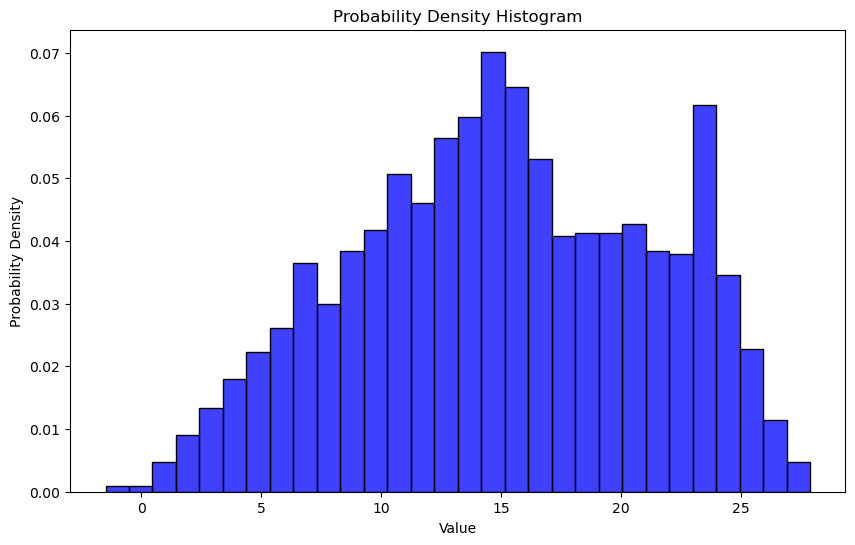

In [28]:
plt.figure(figsize=(10, 6))

# Create a probability density histogram
sns.histplot(Y_test, kde=False, stat='density', bins=30, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Probability Density Histogram')

# Show the plot
plt.show()


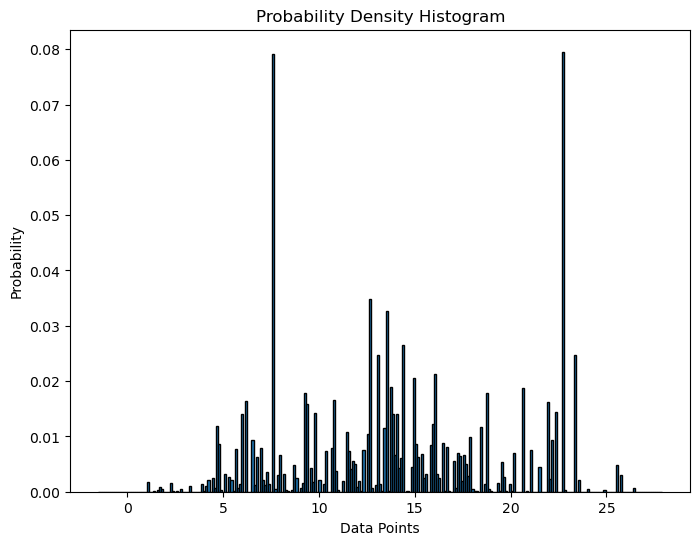

In [29]:
# Plot the probability density histogram
plt.figure(figsize=(8, 6))
plt.hist(y_test, bins=len(y_test), weights=CDF, density=False, edgecolor='black')

# Add labels and title
plt.xlabel('Data Points')
plt.ylabel('Probability')
plt.title('Probability Density Histogram')

# Show the plot
plt.show()


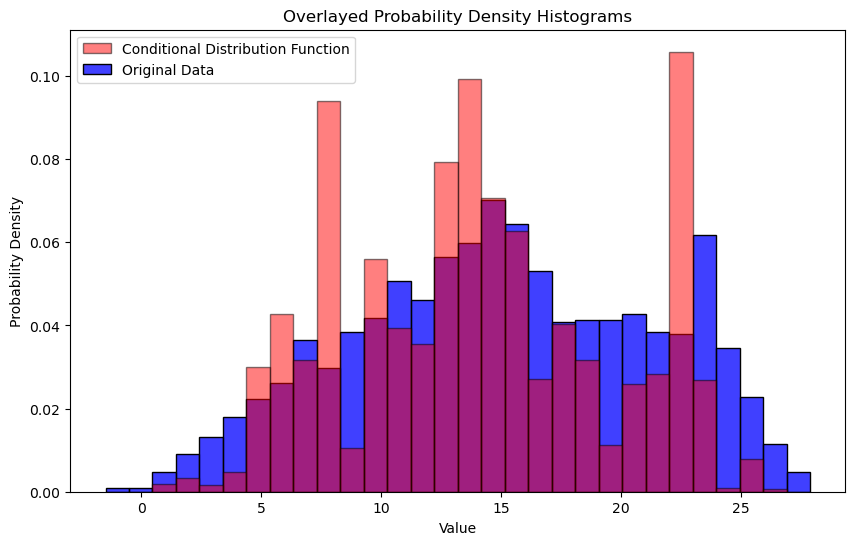

In [30]:
plt.figure(figsize=(10, 6))

# Plot the first histogram (original data)
sns.histplot(Y_test, kde=False, stat='density', bins=30, color='blue', edgecolor='black', label='Original Data')

# Plot the second histogram (conditional distribution function)
plt.hist(y_test, bins=30, weights=CDF, density=False, color='red', alpha=0.5, edgecolor='black', label='Conditional Distribution Function')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('Overlayed Probability Density Histograms')
plt.legend()

# Show the plot
plt.show()
